<a href="https://colab.research.google.com/github/csabot3/liverAItutorial/blob/main/Lesson3_Radiomics_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 3: Basic Radiomics

Now that we have explored how to create segmentations with U-nets in Lesson 2, we will next explore what we can do with these segmentations. For convience, though, we will do this with the ground truth manual segmentations in the CHAOS dataset

In [1]:
#Import packages

!pip install pydicom #Not in Colab by default
!apt-get -qq install pv #Progress bar, also not in Colab

from IPython.display import display,HTML

from PIL import Image
import numpy as np

import os
import shutil
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import pandas as pd
import glob
import sys

     |████████████████████████████████| 2.0 MB 8.3 MB/s 
Selecting previously unselected package pv.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../archives/pv_1.6.6-1_amd64.deb ...
Unpacking pv (1.6.6-1) ...
Setting up pv (1.6.6-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


First, we will introduce a Python package, pyradiomics, which we have not installed or imported briefly. We will wait to use this robust radiomics package until the end of the lesson and instead start by manipulating the data and segmentations with Numpy. However, pyradiomics is an excellent package with robust tools for radiomics, and if you are truly interested in working with radiomics in Python then we would strongly recommend reviewing dedicated pyradiomics tutorials and reading the pyradiomics documentation: https://pyradiomics.readthedocs.io/en/latest/

In [2]:
#First install the new package that we will be using in this lesson
!pip install pyradiomics

     |████████████████████████████████| 188 kB 8.6 MB/s 
     |████████████████████████████████| 48.4 MB 20 kB/s 
     |████████████████████████████████| 109 kB 47.5 MB/s 
     |████████████████████████████████| 546 kB 50.6 MB/s 


For working with pyradiomics, we will also be using SimpleITK: https://simpleitk.org/. Again, since we will only use SimpleITK and pyradiomics briefly in this lesson, we would recommend reviewing a dedicated SimpleITK tutorial and reading the documentation for further understanding of this image analysis tool

In [3]:
import SimpleITK as sitk

from radiomics import featureextractor

Now let's start working with the CHAOS dataset again

In [4]:
#We need CHAOS training data again
!wget -q --show-progress https://zenodo.org/record/3431873/files/CHAOS_Train_Sets.zip?download=1
!unzip -q  CHAOS_Train_Sets.zip\?download\=1

CHAOS_Train_Sets.zi 100%[===================>] 849.51M  4.72MB/s    in 1m 40s  


Let's now pick an example patient to work with (patient 1)

In [5]:
expatientimagepath='./Train_Sets/CT/1/DICOM_anon/'
eximgs=sorted(os.listdir(expatientimagepath))

expatientlabelpath='./Train_Sets/CT/1/Ground/'
exlabels=sorted(os.listdir(expatientlabelpath))

numz=len(eximgs)
print(numz) #This is the number of slices for this series/CT

96


In [6]:
#Volumize the data first
#We know the size of the CT data and labels so we can hard code them in. Otherwise,
#we would want to extract this data from the DICOM files
volCT=np.zeros((512,512,numz))
volseg=np.zeros((512,512,numz)) #We are constructing these 3D arrays in a x-y-z format.
#Later on, awareness of the dimension order expected by different packages will be relevant
#once we start working with pyradiomics and SITK
sliceposls=np.zeros((numz))

for xz in range(0,numz):
  eximg1=expatientimagepath+eximgs[xz]
  exlabel1=expatientlabelpath+exlabels[xz]
  ctex=pydicom.dcmread(eximg1) #Load the DICOM
  huimg=pydicom.pixel_data_handlers.util.apply_modality_lut(ctex.pixel_array,ctex)
  volCT[:,:,xz]=huimg
  volseg[:,:,xz]=1*np.array(Image.open(exlabel1))
  sliceposls[xz]=ctex['SliceLocation'].value #Put slice position in an array




In [7]:
#Let's take the last DICOM loaded and look at the parameters
#Now that we are interested in potentially extracting volume data, we will need to be aware of pixel spacing in the arrays
ctex

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.405493159911658411515822770371320186331
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'VOLUME']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018

In [8]:
ctex['PixelSpacing']

(0028, 0030) Pixel Spacing                       DS: [0.687671, 0.687671]

In [9]:
ctex['PixelSpacing'].value

[0.687671, 0.687671]

In [10]:
pixelxy=ctex['PixelSpacing'].value

So, that tells us are x-y pixel spacing in mm. Now we need to extract information about the z direction

In [11]:
ctex['SliceThickness']  #Slices are 3 mm thick

(0018, 0050) Slice Thickness                     DS: '3.0'

An important caveat is that slice thickness does not necessarily equate to spacing, since the slices will be calculated based on the raw data with overlap. We already made an array of slice locations, though when constructing the volumetric data. So, now let's look at that.

In [12]:
ctex['SliceLocation']

(0020, 1041) Slice Location                      DS: '-226.5'

In [13]:
sliceposls

array([ -84. ,  -85.5,  -87. ,  -88.5,  -90. ,  -91.5,  -93. ,  -94.5,
        -96. ,  -97.5,  -99. , -100.5, -102. , -103.5, -105. , -106.5,
       -108. , -109.5, -111. , -112.5, -114. , -115.5, -117. , -118.5,
       -120. , -121.5, -123. , -124.5, -126. , -127.5, -129. , -130.5,
       -132. , -133.5, -135. , -136.5, -138. , -139.5, -141. , -142.5,
       -144. , -145.5, -147. , -148.5, -150. , -151.5, -153. , -154.5,
       -156. , -157.5, -159. , -160.5, -162. , -163.5, -165. , -166.5,
       -168. , -169.5, -171. , -172.5, -174. , -175.5, -177. , -178.5,
       -180. , -181.5, -183. , -184.5, -186. , -187.5, -189. , -190.5,
       -192. , -193.5, -195. , -196.5, -198. , -199.5, -201. , -202.5,
       -204. , -205.5, -207. , -208.5, -210. , -211.5, -213. , -214.5,
       -216. , -217.5, -219. , -220.5, -222. , -223.5, -225. , -226.5])

Based on inspection, we can see that the spacing is 1.5 mm in the z direction, and then we can store our pixel spacing values

In [14]:
pixelspaceAll=[pixelxy[0],pixelxy[1],1.5]

Now that we have identified the pixel spacing for our volumes, let's move on to some visualization

In [15]:
#We can then visualize the segmentation as a surface with skimage, we will use marching_cubes to extract a surface from the volume
from skimage import measure

verts, faces, normals, values = measure.marching_cubes(volseg, spacing=pixelspaceAll)

You can learn more about the marching cube algorithm that we are using here via the scikit-image documentation: https://scikit-image.org/docs/stable/auto_examples/edges/plot_marching_cubes

One way that we can visualize this 3D data that we have generated with the marching cubes algorithm is by converting the file to an STL format. We can do this with a dedicated package - numpy-stl: https://pypi.org/project/numpy-stl/

We will then use the face and vertex data extracted from our volume with the marching cubes algorithm to generate a mesh that we can convert to an STL file

In [16]:
!pip install numpy-stl

     |████████████████████████████████| 772 kB 2.8 MB/s 
  Created wheel for numpy-stl: filename=numpy_stl-2.16.3-cp37-cp37m-linux_x86_64.whl size=137070 sha256=415c38807a464b7764f339f0314a16bcb4603910658659ad9d52489fbe2c88cf
  Stored in directory: /root/.cache/pip/wheels/06/f4/db/7fac39962a6ba79b7e740892042332083924bff552d4bef41e
Successfully built numpy-stl


In [17]:
from stl import mesh

In [18]:
faces.shape[0]

371872

In [19]:
liverMesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))

In [20]:
for ik, fk in enumerate(faces):
    for jk in range(3):
        liverMesh.vectors[ik][jk] = verts[fk[jk],:]


In [21]:
liverMesh.save('liverExMesh.stl') #Without smoothing the mesh, this is a large STL file

We can view this mesh locally after downloading it with any 3D viewing software of choice. Of note, STL files can also be used for 3D printing.

Now, let's look at the data a bit more and extract some values using the segmentation as a mask. Eventually we are going to use pyradiomics to explore radiomics features for our data but first we will look at some first order features for ourselves before that without utilizing the robust feature extraction capabilities of the pyradiomics package. You can read about different radiomics features in the pyradiomics documentation which is a fantastic resource for learning more about radiomics: https://pyradiomics.readthedocs.io/en/latest/features.html

We will start simple by looking at different statistics and first order features with and without using the mask over our CT volume

In [22]:
np.sum(volseg) #Number of pixels in our liver mask that represent the liver

2079098.0

In [23]:
np.size(volCT) #Number of total pixels in our volume

25165824

In [24]:
100*np.sum(volseg)/np.size(volseg) #Percentage that liver segmentation occupies within the volume

8.261593182881674

In [25]:
segindex=np.where(volseg==1)

In [26]:
volCTindex=volCT[segindex]

In [27]:
volCTindex.shape #Now we have a 1D array of the HU values that correspond to the liver segment

(2079098,)

In [28]:
np.mean(volCTindex) #Mean HU for liver

148.19835332437432

In [29]:
np.mean(volCT) #Mean HU for the entire CT volume, not a very useful number given the amount of empty space

-414.744974176089

In [30]:
#Let's get a coarse index based on tissue relevant HU values
tissueindex=np.where(np.logical_and(volCT>=-120,volCT<300))

In [31]:
volCTtissue=volCT[tissueindex]

In [32]:
np.mean(volCTtissue) #Now perhaps a more relevant HU value comparison after filtering, but still not necessarily useful
#This is why the segmentation can be so beneficial
#if we want to analyze different features across several studies for various pathologies of interest

37.42473358659965

In [33]:
#Let's keep looking at first order features for our liver segmentation

In [34]:
np.min(volCTindex)

-182.0

In [35]:
np.max(volCTindex)

362.0

In [36]:
np.median(volCTindex)

149.0

In [37]:
np.std(volCTindex)

35.93190789194416

Now let's look at the first order features of skew and kurtosis. Skew is essentially measure of asymmetry of the distribution about the mean, while kurtosis can be thought of as the "tailedness" of a distribution with higher values of kurtosis associated with more outliers/more "tailedness" of the distribution. We will look at these briefly by importing from scipy.stats but obviously we are getting to the point where we are almost ready for pyradiomics

The relevant documentation for scipy.stats is here:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html

In [38]:
from scipy.stats import skew
from scipy.stats import kurtosis

print('Skew: '+str(skew(volCTindex)))
print('Kurtosis: '+str(kurtosis(volCTindex)))

Skew: -0.7712698621858187
Kurtosis: 6.990469707016951


Now, before we jump to more radiomics, we will switch briefly to MRI to see how some basic manipulations of our MRI T1 in-phase and T1 out-phase data can enable us to coarsely estimate fat fraction based on the segmentation. There are more sophisticated modern methods for hepatic fat fraction estimation for MRI (e.g. proton density fat fraction) but for illustrative purposes here we will try to use segmentation to mimic the simple calculation of:

[(In-phase Signal)-(Out-phase Signal)]/[2*(In-phase Signal)]

You can read more about this method in Dr. Claude Sirlin's Radiographics commentary:

[Radiographics commentary link](https://pubs.rsna.org/doi/10.1148/027153330290051277?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)

or potentially utilize Dr. Phillip Cheng's online calculator:

https://pcheng.org/calc/hepatic_fat_mri.html


We will start by getting an example MRI volume with T1 in-phase and T1 out-phase data

In [39]:
expatientimagepathMRin='./Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase/'
expatientimagepathMRout='./Train_Sets/MR/1/T1DUAL/DICOM_anon/OutPhase/'
eximgsMRin=sorted(os.listdir(expatientimagepathMRin))
eximgsMRout=sorted(os.listdir(expatientimagepathMRout))

expatientlabelpathMR='./Train_Sets/MR/1/T1DUAL/Ground/'
exlabelsMR=sorted(os.listdir(expatientlabelpathMR))

numzMR=len(exlabelsMR)
print(numzMR) #Number of slices

35


In [40]:
#Now let's look at an example DICOM to get a better idea about the shape and spacing
exMRpick=expatientimagepathMRin+eximgsMRin[10]
mrex=pydicom.dcmread(exMRpick)
mrex

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.260616927513309992437009908581804340445
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0014) Instance Creator UID                UI: 1.3.46.670589.11.20182.5
(

In [41]:
mrex['Rows']

(0028, 0010) Rows                                US: 256

In [42]:
mrex['Columns'] #256 x 256 matrix size

(0028, 0011) Columns                             US: 256

In [43]:
mrex['PixelSpacing'] #Pixels about 1.9 mm apart in the xy plane

(0028, 0030) Pixel Spacing                       DS: [1.89453125, 1.89453125]

In [44]:
mrex['SliceLocation']

(0020, 1041) Slice Location                      DS: '55.0'

In [45]:
mrex['SliceThickness'] #5 mm slice

(0018, 0050) Slice Thickness                     DS: '5.0'

In [46]:
#Now based on how the MR segmentation data is stored in the images,
#we will want our function from lesson 2 again to convert the pixel values
def chaosrelabel(imx1):
  imx1[imx1<50]=0
  imx1[np.where(np.logical_and(imx1>=50,imx1<90))]=1 #Liver
  imx1[np.where(np.logical_and(imx1>=90,imx1<150))]=2 #Right kidney
  imx1[np.where(np.logical_and(imx1>=150,imx1<210))]=3 #Left kidney
  imx1[imx1>=210]=4 #Spleen
  return imx1

In [47]:
#Volumize the MR data first
volMRin=np.zeros((256,256,numzMR)) 
volMRout=np.zeros((256,256,numzMR))
volsegMR=np.zeros((256,256,numzMR))
sliceposlsMRin=np.zeros((numzMR))
sliceposlsMRout=np.zeros((numzMR))

for xz in range(0,numzMR):
  eximg1=expatientimagepathMRin+eximgsMRin[xz]
  eximg2=expatientimagepathMRout+eximgsMRout[xz]
  exlabel1=expatientlabelpathMR+exlabelsMR[xz]
  mrex=pydicom.dcmread(eximg1) #Load the DICOM
  volMRin[:,:,xz]=mrex.pixel_array
  mrex2=pydicom.dcmread(eximg2)
  volMRout[:,:,xz]=mrex2.pixel_array
  volsegMR[:,:,xz]=chaosrelabel(np.array(Image.open(exlabel1)))
  sliceposlsMRin[xz]=mrex['SliceLocation'].value #Put slice position in an array
  sliceposlsMRout[xz]=mrex2['SliceLocation'].value

In [48]:
sliceposlsMRin #Look at the in-phase slice positions

array([  0.        ,   5.5       ,  11.        ,  16.5       ,
        22.        ,  27.5       ,  33.        ,  38.5       ,
        44.        ,  49.5       ,  55.        ,  60.5       ,
        66.        ,  71.5       ,  77.        ,  82.5       ,
        88.        ,  93.5       ,  99.        , 104.5       ,
       110.        , 115.5       , 121.        , 126.5       ,
       132.        , 137.5       , 143.        , 148.5       ,
       154.        , 159.5       , 165.        , 170.50000763,
       176.00000763, 181.50000763, 187.00000763])

In [49]:
sliceposlsMRout #Now the out phase slice positions (same, 5.5 mm apart)

array([  0.        ,   5.5       ,  11.        ,  16.5       ,
        22.        ,  27.5       ,  33.        ,  38.5       ,
        44.        ,  49.5       ,  55.        ,  60.5       ,
        66.        ,  71.5       ,  77.        ,  82.5       ,
        88.        ,  93.5       ,  99.        , 104.5       ,
       110.        , 115.5       , 121.        , 126.5       ,
       132.        , 137.5       , 143.        , 148.5       ,
       154.        , 159.5       , 165.        , 170.50000763,
       176.00000763, 181.50000763, 187.00000763])

In [50]:
MRdiff=volMRin-volMRout #Compute the difference between in phase and out phase

In [51]:
segindexMR=np.where(volsegMR==1)

In [52]:
#Element wise division of the segmentations of MR intensity values according to fat fraction formula
MRfatfrac1=np.divide(MRdiff[segindexMR],2*volMRin[segindexMR])


In [53]:
MRfatfrac1

array([0.28941176, 0.33816425, 0.34814815, ..., 0.20408163, 0.16183575,
       0.12652068])

In [54]:
np.mean(MRfatfrac1)*100 #Normal hepatic fat fraction (less than 5%)

1.6828733399676856

In [55]:
np.std(MRfatfrac1)

0.08528094596162474

In [56]:
np.median(MRfatfrac1)*100

-0.13850415512465375

In [57]:
np.max(MRfatfrac1)*100

49.717514124293785

In [58]:
np.min(MRfatfrac1)*100

-42.23880597014925

In [59]:
np.percentile(MRfatfrac1,[25,75])*100 #Interquartile range

array([-1.67064439,  1.65781091])

So, clearly when looking at the statistics for this estimate of fat fraction, not all of the numbers numerically make sense for every pixel value in the segmentation. However, this patient has normal (less than 5%) hepatic fat fraction. Let's turn this calculation into a function to look at all the training dataset cases

In [60]:
MRhighlevelpath='./Train_Sets/MR/'
MRptls=os.listdir(MRhighlevelpath)
MRptls

['21',
 '10',
 '20',
 '15',
 '2',
 '36',
 '5',
 '33',
 '19',
 '13',
 '8',
 '1',
 '31',
 '22',
 '32',
 '3',
 '38',
 '34',
 '37',
 '39']

In [61]:
def MRfatcalcfunc(ptpick):
  expatientimagepathMRin='./Train_Sets/MR/'+str(ptpick)+'/T1DUAL/DICOM_anon/InPhase/'
  expatientimagepathMRout='./Train_Sets/MR/'+str(ptpick)+'/T1DUAL/DICOM_anon/OutPhase/'
  eximgsMRin=sorted(os.listdir(expatientimagepathMRin))
  eximgsMRout=sorted(os.listdir(expatientimagepathMRout))

  expatientlabelpathMR='./Train_Sets/MR/'+str(ptpick)+'/T1DUAL/Ground/'
  exlabelsMR=sorted(os.listdir(expatientlabelpathMR))

  numzMR=len(exlabelsMR)

  #Take a first look at the DICOM values
  exMRpick=expatientimagepathMRin+eximgsMRin[0]
  mrex=pydicom.dcmread(exMRpick)
  numrow=mrex['Rows'].value
  numcol=mrex['Columns'].value

  #Volumize the MR data first
  volMRin=np.zeros((numrow,numcol,numzMR))
  volMRout=np.zeros((numrow,numcol,numzMR))
  volsegMR=np.zeros((numrow,numcol,numzMR))
  sliceposlsMRin=np.zeros((numzMR))
  sliceposlsMRout=np.zeros((numzMR))

  for xz in range(0,numzMR):
    eximg1=expatientimagepathMRin+eximgsMRin[xz]
    eximg2=expatientimagepathMRout+eximgsMRout[xz]
    exlabel1=expatientlabelpathMR+exlabelsMR[xz]
    mrex=pydicom.dcmread(eximg1) #Load the DICOM
    volMRin[:,:,xz]=mrex.pixel_array
    mrex2=pydicom.dcmread(eximg2)
    volMRout[:,:,xz]=mrex2.pixel_array
    volsegMR[:,:,xz]=chaosrelabel(np.array(Image.open(exlabel1)))
    sliceposlsMRin[xz]=mrex['SliceLocation'].value #Put slice position in an array
    sliceposlsMRout[xz]=mrex2['SliceLocation'].value

  MRdiff=volMRin-volMRout
  segindexMR=np.where(volsegMR==1)
  MRfatfrac1=np.divide(MRdiff[segindexMR],2*volMRin[segindexMR])
  fatcalcmean=np.mean(MRfatfrac1)*100

  return fatcalcmean

In [62]:
#Now use the function to get the mean fat fractions in the hepatic segmentations which will take a few seconds
fatmeanls=[]
for fx in MRptls:
  fatmeanls.append(MRfatcalcfunc(fx))



Text(0.5, 1.0, 'Hepatic Fat Fraction Estimations')

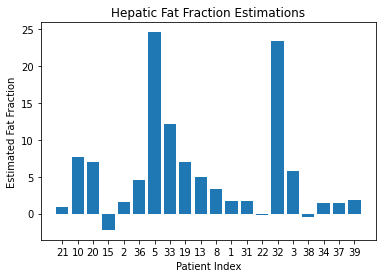

In [63]:
plt.bar(MRptls,fatmeanls)
plt.xlabel('Patient Index')
plt.ylabel('Estimated Fat Fraction')
plt.title('Hepatic Fat Fraction Estimations')

In [64]:
fatmeanarray=np.array(fatmeanls)
len(fatmeanarray[fatmeanarray>5])

8

In [65]:
len(fatmeanarray)

20

Okay, so these results are relatively interesting. We have 20 patients in the training dataset and 8 (40%) have fat fraction estimated as greater than 5% by our methods. We also have several interesting cases that we will want to further visualize. We could display images programmatically here, but we would actually recommend viewing the data locally with dedicated DICOM viewer software for this inspection process.

Case 15 with the negative estimated fat fraction is interesting because the liver and spleen are T2 hypointense to skeletal muscle (likely related to iron deposition, see references such as https://www.ajronline.org/doi/full/10.2214/ajr.174.4.1740965 for further details).

Case 5 and 32 also catch our attention. As expected, case 5 and 32 demonstrate significant out of phase T1 drop out as expected in hepatic steatosis. 

This data is pretty interesting and something we might want to use later in Lesson 4... so let's save it to a CSV file.

We haven't used Pandas yet (even though we have been importing it) so now let's create a dataframe from our patient index list and fat fraction estimate and then save the dataframe as a CSV.

You can learn more about Pandas here: https://pandas.pydata.org/docs/

In [66]:
df = pd.DataFrame(list(zip(MRptls, fatmeanls)),columns =['PatientIndex', 'FatFraction']) #Create a dataframe from our lists

In [67]:
df #Look at it

,PatientIndex,FatFraction
0,21,0.943073
1,10,7.682899
2,20,7.045923
3,15,-2.221292
4,2,1.508953
5,36,4.550121
6,5,24.624095
7,33,12.194106
8,19,6.961539
9,13,5.011798


In [68]:
df.to_csv('MRfatfracs.csv') #Save it, you can then download this but it will be in the Github repo, ready for lesson 4

Now that we've spent some time interacting with and visualizing the data. It's time to utilize the pyradiomics package for more advanced radiomics analysis. First we will do a bit of data reformatting with SITK.

With SITK, we can read in our series of individual DICOM slices and then package them into a Nifti format file. The name Nifti is from Neuroimaging Informatics Technology Initiative, although obviously we can use this format for more than just neuroimaging. 

In [69]:
sCTpath='./Train_Sets/CT/1/DICOM_anon/'
sreader=sitk.ImageSeriesReader()
dnames=sreader.GetGDCMSeriesFileNames(sCTpath)
sreader.SetFileNames(dnames)
imageEx=sreader.Execute()
sitk.WriteImage(imageEx,'exampleImage.nii.gz') #Write it as a Nifti format

We now have converted our folder of DICOM files to a single Nifti format image

In [70]:
imageEx.GetOrigin() #Check the origin data in the SITK image

(-167.7859, -176.0438, -226.5)

In [71]:
imageEx.GetSpacing() #Check the image spacing

(0.687671, 0.687671, 1.5)

In [72]:
imageEx.GetSize() #Get the size

(512, 512, 96)

In [73]:
imageEx.GetDirection()

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

We have checked on all of these components (origin, spacing, size, and direction) as they are important to ITK and SITK given that SITK treats image data as being in essentially a physical space. This is further detailed in the Simple ITK Fundamental Concpets documentation which is great material to review: https://simpleitk.readthedocs.io/en/master/fundamentalConcepts.html

In [74]:
exSz=imageEx.GetSize()
exSz

(512, 512, 96)

Now we will also want to reformat the corresponding label images which are binary PNGs

An important caveat here is that when we convert our list of label images to a Numpy array and then use the SITK function GetImageFromArray, SITK has certain expectations about the format of the Numpy array. When verbosely using a for loop to feed images into a 3D array, we have typically previously used x-y-z dimensions. But, SITK expects Numpy arrays to have the z dimension first so we are changing how we loop through the images in the next cell. We are also reversing the order that we loop through the images in the z direction based on the position data.

The important takeaway here, is that there could easily potentially be a mismatch between a loaded image volume and a loaded segmentation if not careful in understanding different libraries and packages being useful. Visualization of data is always important and here it can be incredibly helpful for checking that segmentations and the corresponding image data match in orientation. Additionally, numerical checks can be performed. For example, we know our expected mean HU value for the liver segmentation is approximately 148 HU. If we have a mismatch from this expected value, then this can prompt troubleshooting.

You can read more about this potential issue in a dedicated SITK tutorial notebook - [Tutorial notebook link](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/01_Image_Basics.html)

In [75]:
sCTlabelpath='./Train_Sets/CT/1/Ground/'
labelvol=np.zeros((96,512,512))
labelnames=sorted(os.listdir(sCTlabelpath))
for xz in range(0,exSz[2]):
  idxz=exSz[2]-xz-1
  labeltemp=sCTlabelpath+labelnames[xz]
  labelvol[idxz,:,:]=1*np.array(Image.open(labeltemp))




In [76]:
labelvol.shape

(96, 512, 512)

In [77]:
#Then with the Numpy array volume we can convert to SITK

labelSTK=sitk.GetImageFromArray(labelvol)
labelSTK.SetOrigin(imageEx.GetOrigin()) #Use the DICOM data to define the origin
labelSTK.SetSpacing(imageEx.GetSpacing()) #Again use DICOM data to define spacing


In [78]:
labelSTK.GetOrigin()

(-167.7859, -176.0438, -226.5)

In [79]:
labelSTK.GetSpacing()

(0.687671, 0.687671, 1.5)

In [80]:
labelSTK.GetSize() #Check the size

(512, 512, 96)

In [81]:
labelSTK.GetDirection()

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [82]:
#Write the label volume as Nifti
sitk.WriteImage(labelSTK,'exampleLabel.nii.gz') 

If desired, we can then download our NIfTI files to view locally using dedicated software such as 3D slicer: https://www.slicer.org/

or

Mango: https://ric.uthscsa.edu/mango/

In [83]:
#We can then load back to prepare for input into the pyradiomics feature extractor
radVol1=sitk.ReadImage('exampleImage.nii.gz')
radSeg1= sitk.ReadImage('exampleLabel.nii.gz')

Okay, now that we have our example case with the image and segmentation data in NIfTI format, let's finally use Pyradiomics. We will only briefly use the RadiomicsFeatureExtractor() method here, but again we recommend reviewing a dedicated pyradiomics or other radiomics tutorial for further details.

In [84]:
extractor = featureextractor.RadiomicsFeatureExtractor()

In [85]:
featureVector = extractor.execute(radVol1, radSeg1) #This will take about 1 minute for the example case

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Now we can visualize all the calculated features for our image data and segmentation

In [86]:
for featureName in featureVector.keys():
    print('%s: %s' % (featureName, featureVector[featureName]))

diagnostics_Versions_PyRadiomics: v3.0.1
diagnostics_Versions_Numpy: 1.21.5
diagnostics_Versions_SimpleITK: 2.1.1
diagnostics_Versions_PyWavelet: 1.3.0
diagnostics_Versions_Python: 3.7.13
diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
diagnostics_Image-original_Hash: da045d1595218572da69fcf06b688fe18d9fd23e
diagnostics_Image-original_Dimensionality: 3D
diagnostics_Image-original_Spacing: (0.6876710057258606, 0.6876710057258606, 1.5)
diagnostics_Image-original_Size: (512, 512, 96)
diagnostics_Image-original_Mean: -414.744974176089
diagnostics_Image-original_Minimum: -1200.0
diagnostics_Image-original_Maximum:

So, there is much, much more that we can do with the CHAOS dataset and pyradiomics, but we will use this as a stopping point for lesson 3, and instead leave further radiomics exploration up to the reader. 